In [1]:
# Load libraries
### vector data
import geopandas as gpd
import pandas as pd

### raster data
import rioxarray as rxr
import xarray as xr

### maps and plots
import holoviews as hv
import hvplot.pandas
import hvplot.xarray

### open street map
from osmnx import features as osm
import osmnx as ox

### file structure
import os
import pathlib

### earthpy
import earthpy
import earthpy.api.appeears as eaapp

In [2]:
### set up project and folder for data
project = earthpy.Project("Konza Prarie Vegetation", dirname = 'Konza_ndvi')

In [3]:
# get polygon for area of interest
### search for PRNS
Konza_gdf = ox.geocode_to_gdf(
    'Konza Prairie Biological Station')

### check it out
Konza_gdf

,geometry,bbox_west,bbox_south,bbox_east,bbox_north,place_id,osm_type,osm_id,lat,lon,class,type,place_rank,importance,addresstype,name,display_name
0,"POLYGON ((-96.61513 39.11099, -96.6151 39.1104...",-96.615135,39.065472,-96.538652,39.135937,304377049,way,104952723,39.100201,-96.576798,boundary,protected_area,25,0.066695,protected_area,Konza Prairie Biological Station,"Konza Prairie Biological Station, Riley County..."


<Axes: >

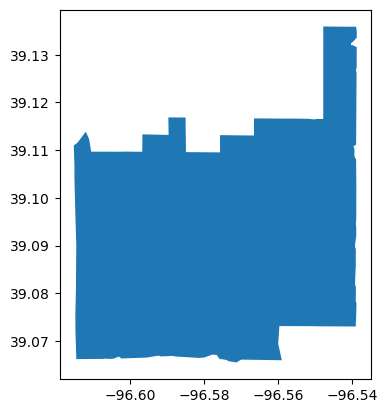

In [4]:
### make a quick plot
Konza_gdf.plot()

In [ ]:
# Get NDVI for area of interest
### initialize AppeearsDownloader for MODIS NDVI data
### set parameters
ndvi_downloader = eaapp.AppeearsDownloader(

    ### give your download a name
    download_key = "Konza_ndvi",

    ### tell it to put the data in your project that you already defined
    project = project,

    ### specify the MODIS product you want
    product = 'MOD13Q1.061',
    layer = '_250m_16_days_NDVI',

    ### choose a start date and end date
    start_date = "06-01",
    end_date = "07-30",

    ### recurring means you want those dates over multiple years
    recurring = True,

    ### specify the range of years you want
    year_range = [2004, 2012],

    ### specify the polygon you want to get NDVI data for
    polygon = Konza_gdf
)

In [ ]:
ndvi_downloader

In [ ]:
### download the prepared download -- this can take a while!
ndvi_downloader.download_files(cache=True)

In [5]:
### get a sorted list of NDVI file paths
ndvi_paths = sorted(list(project.project_dir.rglob('*NDVI*.tif')))

ndvi_paths

[PosixPath('/workspaces/data/konza_ndvi/Konza_ndvi/MOD13Q1.061_2004138_to_2012212/MOD13Q1.061__250m_16_days_NDVI_doy2004145000000_aid0001.tif'),
 PosixPath('/workspaces/data/konza_ndvi/Konza_ndvi/MOD13Q1.061_2004138_to_2012212/MOD13Q1.061__250m_16_days_NDVI_doy2004161000000_aid0001.tif'),
 PosixPath('/workspaces/data/konza_ndvi/Konza_ndvi/MOD13Q1.061_2004138_to_2012212/MOD13Q1.061__250m_16_days_NDVI_doy2004177000000_aid0001.tif'),
 PosixPath('/workspaces/data/konza_ndvi/Konza_ndvi/MOD13Q1.061_2004138_to_2012212/MOD13Q1.061__250m_16_days_NDVI_doy2004193000000_aid0001.tif'),
 PosixPath('/workspaces/data/konza_ndvi/Konza_ndvi/MOD13Q1.061_2004138_to_2012212/MOD13Q1.061__250m_16_days_NDVI_doy2004209000000_aid0001.tif'),
 PosixPath('/workspaces/data/konza_ndvi/Konza_ndvi/MOD13Q1.061_2004138_to_2012212/MOD13Q1.061__250m_16_days_NDVI_doy2005145000000_aid0001.tif'),
 PosixPath('/workspaces/data/konza_ndvi/Konza_ndvi/MOD13Q1.061_2004138_to_2012212/MOD13Q1.061__250m_16_days_NDVI_doy2005161000000_

In [6]:
len(ndvi_paths)

45

In [7]:
doy_start = -25
doy_end = -19

# Loop through each NDVI image
ndvi_das = []
for ndvi_path in ndvi_paths:
    # Get date from file name
    doy = ndvi_path.name[doy_start:doy_end]
    date = pd.to_datetime(doy, format='%Y%j')

    # Open dataset
    da = rxr.open_rasterio(ndvi_path, mask_and_scale=True).squeeze()

    # Add date dimension and clean up metadata
    da = da.assign_coords({'date': date})
    da = da.expand_dims({'date': 1})
    da.name = 'NDVI'

    # Prepare for concatenation
    ndvi_das.append(da)

#len(ndvi_das)
ndvi_das

[<xarray.DataArray 'NDVI' (date: 1, y: 35, x: 38)> Size: 5kB
 array([[[0.53279996, 0.53279996, 0.5589    , ..., 0.7866    ,
          0.69049996, 0.69049996],
         [0.49179998, 0.49179998, 0.6343    , ..., 0.8135    ,
          0.8135    , 0.6964    ],
         [0.5209    , 0.5209    , 0.6299    , ..., 0.7973    ,
          0.7973    , 0.69089997],
         ...,
         [0.8168    , 0.8168    , 0.7854    , ..., 0.7926    ,
          0.7926    , 0.7111    ],
         [0.7191    , 0.7837    , 0.8168    , ..., 0.7926    ,
          0.7926    , 0.70159996],
         [0.6692    , 0.6616    , 0.6012    , ..., 0.7759    ,
          0.7759    , 0.543     ]]], shape=(1, 35, 38), dtype=float32)
 Coordinates:
     band         int64 8B 1
   * x            (x) float64 304B -96.62 -96.61 -96.61 ... -96.54 -96.54 -96.54
   * y            (y) float64 280B 39.14 39.13 39.13 39.13 ... 39.07 39.07 39.07
     spatial_ref  int64 8B 0
   * date         (date) datetime64[ns] 8B 2004-01-14
 Attributes:


In [8]:
# Combine NDVI images from all dates
da = xr.combine_by_coords(ndvi_das, coords=['date'])
da

/tmp/ipykernel_9241/3619952311.py:2: FutureWarning: In a future version of xarray the default value for compat will change from compat='no_conflicts' to compat='override'. This is likely to lead to different results when combining overlapping variables with the same name. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set compat explicitly.
  da = xr.combine_by_coords(ndvi_das, coords=['date'])
/tmp/ipykernel_9241/3619952311.py:2: FutureWarning: In a future version of xarray the default value for compat will change from compat='no_conflicts' to compat='override'. This is likely to lead to different results when combining overlapping variables with the same name. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set compat explicitly.
  da = xr.combine_by_coords(ndvi_das, coords=['date'])


<xarray.Dataset> Size: 240kB
Dimensions:      (date: 45, y: 35, x: 38)
Coordinates:
    band         int64 8B 1
  * x            (x) float64 304B -96.62 -96.61 -96.61 ... -96.54 -96.54 -96.54
  * y            (y) float64 280B 39.14 39.13 39.13 39.13 ... 39.07 39.07 39.07
    spatial_ref  int64 8B 0
  * date         (date) datetime64[ns] 360B 2004-01-14 2004-01-16 ... 2012-01-20
Data variables:
    NDVI         (date, y, x) float32 239kB 0.5328 0.5328 ... 0.4218 0.3491

In [9]:
# Calculate the difference in NDVI
ndvi_diff = (
    da.sel(date=slice('2008', '2012'))
    .mean('date')
    .NDVI 
    
    - da.sel(date=slice('2004', '2008'))
    .mean('date')
    .NDVI
)

ndvi_diff

<xarray.DataArray 'NDVI' (y: 35, x: 38)> Size: 5kB
array([[ 0.06009209,  0.06009209,  0.03429198, ...,  0.00743198,
        -0.00204802, -0.00204802],
       [ 0.04198003,  0.04198003,  0.03021204, ...,  0.00706387,
         0.00706387, -0.00228   ],
       [ 0.03881192,  0.02630001,  0.03782398, ..., -0.00181991,
        -0.00181991,  0.01724392],
       ...,
       [ 0.014956  ,  0.014956  ,  0.00109196, ...,  0.001436  ,
         0.001436  ,  0.01158005],
       [ 0.02146399,  0.02022797, -0.00556004, ..., -0.01079619,
        -0.01079619,  0.00913203],
       [ 0.01238   ,  0.01848787,  0.04098397, ..., -0.00173992,
        -0.00173992, -0.00229996]], shape=(35, 38), dtype=float32)
Coordinates:
    band         int64 8B 1
  * x            (x) float64 304B -96.62 -96.61 -96.61 ... -96.54 -96.54 -96.54
  * y            (y) float64 280B 39.14 39.13 39.13 39.13 ... 39.07 39.07 39.07
    spatial_ref  int64 8B 0

In [11]:
# Plot the NDVI difference

(ndvi_diff.hvplot(x='x', y='y', cmap='PiYG', 
                 geo=True, title='Change in NDVI at Konza Prairie\n2008-2012 vs. 2004-2008')
*

Konza_gdf.hvplot(geo=True, fill_color=None, line_color='grey'))

:Overlay
   .Image.I    :Image   [x,y]   (NDVI)
   .Polygons.I :Polygons   [Longitude,Latitude]

<Axes: >

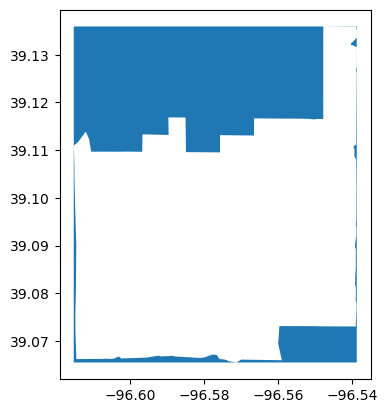

In [ ]:
# Compute the area outside the Konza Prairie boundary

outside_Konza_gdf = (
    gpd.GeoDataFrame(geometry=Konza_gdf.envelope)
    .overlay(Konza_gdf, how='difference'))

outside_Konza_gdf.plot()

In [13]:
# Clip NDVI data to both inside and outside the boundary
ndvi_inside = da.rio.clip(Konza_gdf.geometry, from_disk=True)
print(ndvi_inside)

ndvi_outside = da.rio.clip(outside_Konza_gdf.geometry, from_disk=True)
print(ndvi_outside)

<xarray.Dataset> Size: 221kB
Dimensions:      (x: 36, y: 34, date: 45)
Coordinates:
    band         int64 8B 1
  * x            (x) float64 288B -96.61 -96.61 -96.61 ... -96.54 -96.54 -96.54
  * y            (y) float64 272B 39.13 39.13 39.13 39.13 ... 39.07 39.07 39.07
  * date         (date) datetime64[ns] 360B 2004-01-14 2004-01-16 ... 2012-01-20
    spatial_ref  int64 8B 0
Data variables:
    NDVI         (date, y, x) float32 220kB nan nan nan nan ... nan nan nan nan
<xarray.Dataset> Size: 221kB
Dimensions:      (x: 36, y: 34, date: 45)
Coordinates:
    band         int64 8B 1
  * x            (x) float64 288B -96.61 -96.61 -96.61 ... -96.54 -96.54 -96.54
  * y            (y) float64 272B 39.13 39.13 39.13 39.13 ... 39.07 39.07 39.07
  * date         (date) datetime64[ns] 360B 2004-01-14 2004-01-16 ... 2012-01-20
    spatial_ref  int64 8B 0
Data variables:
    NDVI         (date, y, x) float32 220kB 0.4918 0.6343 ... 0.4218 0.4218


In [14]:
# Compute mean annual July NDVI
july_ndvi_inside_df = (ndvi_inside
                       .groupby(ndvi_inside.date.dt.year)
                       .mean(...)
                       .NDVI.to_dataframe())
print('Mean NDVI inside Konza Prairie\n', july_ndvi_inside_df.head())

july_ndvi_outside_df = (ndvi_outside
                       .groupby(ndvi_outside.date.dt.year)
                       .mean(...)
                       .NDVI.to_dataframe())
print('Mean NDVI outside Konza Prairie\n', july_ndvi_outside_df.head())

Mean NDVI inside Konza Prairie
       band  spatial_ref      NDVI
year                             
2004     1            0  0.782115
2005     1            0  0.687610
2006     1            0  0.685558
2007     1            0  0.744759
2008     1            0  0.760001
Mean NDVI outside Konza Prairie
       band  spatial_ref      NDVI
year                             
2004     1            0  0.690666
2005     1            0  0.636587
2006     1            0  0.629236
2007     1            0  0.649652
2008     1            0  0.684952


In [15]:
# Join inside and outside Konza df and rename columns
july_ndvi_df = (july_ndvi_inside_df[['NDVI']]
                .join(july_ndvi_outside_df[['NDVI']], 
                      lsuffix=' Inside Konza Prairie', 
                      rsuffix=' Outside Konza Prairie'))
july_ndvi_df

,NDVI Inside Konza Prairie,NDVI Outside Konza Prairie
year,,
2004,0.782115,0.690666
2005,0.687610,0.636587
2006,0.685558,0.629236
2007,0.744759,0.649652
2008,0.760001,0.684952
2009,0.778717,0.723701
2010,0.777798,0.728336
2011,0.729234,0.681873
2012,0.615042,0.606430


In [16]:
# Plot mean NDVI inside and outside Konza boundary
july_ndvi_df.hvplot(title='Mean July NDVI Inside and Outside Konza Prairie')

:NdOverlay   [Variable]
   :Curve   [year]   (value)

In [19]:
# Calculate difference inside and outside the boundary
july_ndvi_df['Difference'] = (july_ndvi_df['NDVI Inside Konza Prairie'] 
                              - july_ndvi_df['NDVI Outside Konza Prairie'])
july_ndvi_df

,NDVI Inside Konza Prairie,NDVI Outside Konza Prairie,Difference
year,,,
2004,0.782115,0.690666,0.091449
2005,0.687610,0.636587,0.051023
2006,0.685558,0.629236,0.056322
2007,0.744759,0.649652,0.095107
2008,0.760001,0.684952,0.075049
2009,0.778717,0.723701,0.055016
2010,0.777798,0.728336,0.049463
2011,0.729234,0.681873,0.047361
2012,0.615042,0.606430,0.008612


In [20]:
# Plot difference inside and outside the boundary
july_ndvi_df.Difference.hvplot(
    title='Difference in NDVI within and outside Konza Prairie')

:Curve   [year]   (Difference)